In [1]:
!pip install transformers datasets tweet-preprocessor ray[tune] hyperopt

     |████████████████████████████████| 1.4MB 6.7MB/s 
     |████████████████████████████████| 163kB 51.9MB/s 
     |████████████████████████████████| 23.1MB 1.7MB/s 
     |████████████████████████████████| 890kB 54.4MB/s 
     |████████████████████████████████| 2.9MB 50.3MB/s 
     |████████████████████████████████| 245kB 50.6MB/s 
     |████████████████████████████████| 17.7MB 202kB/s 
     |████████████████████████████████| 1.3MB 52.5MB/s 
     |████████████████████████████████| 2.9MB 51.3MB/s 
     |████████████████████████████████| 204kB 52.0MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
     |████████████████████████████████| 81kB 11.6MB/s 
     |████████████████████████████████| 133kB 54.3MB/s 
     |████████████████████████████████| 317kB 46.1MB/s 
     |████████████████████████████████| 143kB 53.5MB/s 
     |████████████████████████████████| 296kB 49.8MB/s 
     |████████████████████████████████| 61kB 8.3MB/s

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import preprocessor as p # tweet-preprocessor
import nltk
import re
import seaborn as sns
import torch

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy.special import softmax
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
# dataset_dem = pd.read_csv('/content/drive/MyDrive/democrat_tweets_v2.csv')
# dataset_gop = pd.read_csv('/content/drive/MyDrive/republican_tweets_v2.csv')

# dataset_dem["label"] = "Democrat"
# dataset_gop["label"] = "Republican"

# dataset_final = pd.concat([dataset_dem, dataset_gop])

dataset = pd.read_csv("/content/drive/MyDrive/Copy of 2020_labled_political_tweets.csv.zip")
for index, row in dataset.iterrows():
    if str(row['party']) !="D":
      if str(row["party"])!="R":
        dataset.drop(index, inplace=True)

# dataset_final=dataset.reset_index(drop=True, inplace=True)
# dataset_final.head()

In [71]:
dataset.head()
newDataset = dataset.copy()
newDataset.head()
newDataset = newDataset.head([5000])
# dataset_final=dataset
# dataset_final.head()
# dataset_final.rename(columns={"party": "label"},inplace=True)
# dataset_final.head()

TypeError: ignored

In [54]:
newDataset.rename(columns={"party": "label"},inplace=True)
newDataset.reset_index(drop=True, inplace=True)
newDataset.head()

,Unnamed: 0,id,screen_name,user_id,time,link,text,source,label
0,1,1212432932746473472,RepLoriTrahan,1079802482640019456,2020-01-01T12:58:31-05:00,https://www.twitter.com/RepLoriTrahan/statuses...,I am proud of the work we’ve done over the pas...,Twitter for iPhone,D
1,2,1212390455729696768,RepDwightEvans,90639372,2020-01-01T10:09:44-05:00,https://www.twitter.com/RepDwightEvans/statuse...,2/ @MorethanmySLE – a cancer survivor and lupu...,Twitter for iPhone,D
2,3,1212250054788038656,RepThomasMassie,975200486,2020-01-01T00:51:50-05:00,https://www.twitter.com/RepThomasMassie/status...,"@ceQs17 Why are our people in Iraq, and how di...",Twitter for iPhone,R
3,4,1212500813593169920,SenCoryGardner,235217558,2020-01-01T17:28:15-05:00,https://www.twitter.com/SenCoryGardner/statuse...,@EnergyGOP @BLMNational @SenatorBennet @Senate...,Twitter Web App,R
4,6,1212239323392856064,RepGraceMeng,1051127714,2020-01-01T00:09:11-05:00,https://www.twitter.com/RepGraceMeng/statuses/...,"It’s 2020! As we enter a new decade, I wish ev...",Twitter for iPhone,D


In [55]:
# dataset_final = dataset_final.rename(columns={"party": "label"})
LABEL_MAP = {
    "D": 0,
    "R": 1
}

def buildLabels(row):
    return LABEL_MAP.get(row["label"])

def cleanTweet(row):
  tweet = row["text"]
  tweet = str(p.clean(tweet))
  tweet = re.sub(r'[^\w\s]', '', tweet) # punctuation
  tweet = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", tweet) # numbers
  return tweet

  
newDataset["label"] = newDataset.apply(lambda row: buildLabels(row), axis=1)
newDataset["clean_text"] = newDataset.apply(lambda row: cleanTweet(row), 
                                                  axis=1)

In [56]:
newDataset.head()

,Unnamed: 0,id,screen_name,user_id,time,link,text,source,label,clean_text
0,1,1212432932746473472,RepLoriTrahan,1079802482640019456,2020-01-01T12:58:31-05:00,https://www.twitter.com/RepLoriTrahan/statuses...,I am proud of the work we’ve done over the pas...,Twitter for iPhone,0,I am proud of the work weve done over the past...
1,2,1212390455729696768,RepDwightEvans,90639372,2020-01-01T10:09:44-05:00,https://www.twitter.com/RepDwightEvans/statuse...,2/ @MorethanmySLE – a cancer survivor and lupu...,Twitter for iPhone,0,a cancer survivor and lupus warrior spoke wi...
2,3,1212250054788038656,RepThomasMassie,975200486,2020-01-01T00:51:50-05:00,https://www.twitter.com/RepThomasMassie/status...,"@ceQs17 Why are our people in Iraq, and how di...",Twitter for iPhone,1,Why are our people in Iraq and how did Iran co...
3,4,1212500813593169920,SenCoryGardner,235217558,2020-01-01T17:28:15-05:00,https://www.twitter.com/SenCoryGardner/statuse...,@EnergyGOP @BLMNational @SenatorBennet @Senate...,Twitter Web App,1,This year the first ever statelevel measuremen...
4,6,1212239323392856064,RepGraceMeng,1051127714,2020-01-01T00:09:11-05:00,https://www.twitter.com/RepGraceMeng/statuses/...,"It’s 2020! As we enter a new decade, I wish ev...",Twitter for iPhone,0,Its As we enter a new decade I wish everybody...


In [57]:
dataset_clf = newDataset[["clean_text", "label"]]
dataset_clf.reset_index(drop=True, inplace=True)

In [58]:
dataset_clf.head()
# dataset_final.head()
# dataset.head()

,clean_text,label
0,I am proud of the work weve done over the past...,0
1,a cancer survivor and lupus warrior spoke wi...,0
2,Why are our people in Iraq and how did Iran co...,1
3,This year the first ever statelevel measuremen...,1
4,Its As we enter a new decade I wish everybody...,0


In [59]:
X_train, X_val, y_train, y_val = train_test_split(dataset_clf.index.values, 
                                                  dataset_clf.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=dataset_clf.label.values)

dataset_clf['data_type'] = ['not_set']*dataset_final.shape[0]

dataset_clf.loc[X_train, 'data_type'] = 'train'
dataset_clf.loc[X_val, 'data_type'] = 'test'

dataset_train = dataset_clf.loc[dataset_clf.data_type == 'train']
dataset_test = dataset_clf.loc[dataset_clf.data_type == 'test']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [65]:
def get_dataloaders(data, batch_size):
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                            do_lower_case=True)
  # tokenize train and test data so BERT can understand it
  encoded_data_train = tokenizer.batch_encode_plus(
      data[data.data_type=='train'].clean_text.values, 
      add_special_tokens=True, 
      return_attention_mask=True, 
      padding=True,
      max_length=64, 
      return_tensors='pt'
  )

  encoded_data_test = tokenizer.batch_encode_plus(
      data[data.data_type=='test'].clean_text.values, 
      add_special_tokens=True, 
      return_attention_mask=True, 
      padding=True, 
      max_length=64, 
      return_tensors='pt'
  )


  # destructure out the input_ids, attention masks, and labels from tokenizer & encoder output
  input_ids_train = encoded_data_train['input_ids']
  attention_masks_train = encoded_data_train['attention_mask']
  labels_train = torch.tensor(data[data.data_type=='train'].label.values)

  input_ids_test = encoded_data_test['input_ids']
  attention_masks_test = encoded_data_test['attention_mask']
  labels_test = torch.tensor(data[data.data_type=='test'].label.values)

  train_data = TensorDataset(input_ids_train, attention_masks_train, labels_train)
  test_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)

  train_dataloader = DataLoader(train_data, 
                                sampler=RandomSampler(train_data), 
                                batch_size=batch_size)

  test_dataloader = DataLoader(test_data,
                              sampler=SequentialSampler(test_data),
                              batch_size=batch_size)
  
  return train_dataloader, test_dataloader

In [61]:
def auc_score(preds, labels):
  soft_preds = softmax(preds, axis=1) # logit -> probability
  if np.shape(preds)[1] > 2: # check for multi-class
    return roc_auc_score(labels, soft_preds, multi_class='ovr')
  else:
    soft_preds = soft_preds[:,1]
    return roc_auc_score(labels, soft_preds)

def acc_score_by_class(preds, labels):
  label_dict_inverse = {v: k for k, v in LABEL_MAP.items()} 

  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  for label in np.unique(labels_flat):
    y_preds = preds_flat[labels_flat==label]
    y_true = labels_flat[labels_flat==label]
    print(f'Class: {label_dict_inverse[label]}')
    print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [62]:
def evaluate(model, dataloader, device):
  model.eval()

  loss_val_total = 0
  predictions, true_vals = [], []
  
  for batch in dataloader:
      
      # convert data to CUDA
      batch = tuple(b.to(device) for b in batch)
      
      inputs = {
          'input_ids':      batch[0],
          'attention_mask': batch[1],
          'labels':         batch[2],
      }

      with torch.no_grad():        
          outputs = model(**inputs) # get predictions
          
      loss = outputs[0]
      logits = outputs[1]
      loss_val_total += loss.item()

      logits = logits.detach().cpu().numpy()
      label_ids = inputs['labels'].cpu().numpy()
      predictions.append(logits)
      true_vals.append(label_ids)
  
  loss_val_avg = loss_val_total/len(dataloader) 
  
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
          
  return loss_val_avg, predictions, true_vals

In [69]:
def train_and_hyperparam_search(config,
                                model_init, # function to init a clean version of the net
                                data,       # data as Pandas array
                                cv          # rounds of cross-validation
                                ):
  losses = []
  aucs = []
  skf = StratifiedKFold(n_splits=cv, shuffle=True)
  for train_idx, test_idx in skf.split(data.clean_text, data.label):
    model = model_init()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    print(f"Device: {device}")

    optimizer = AdamW(model.parameters(),
                    lr=config['lr'],
                    eps=1e-8) # keep this the same, just prevents exploding gradients
    
    data.loc[train_idx, 'data_type'] = 'train'
    data.loc[test_idx, 'data_type'] = 'test'
    
    train_dataloader, test_dataloader = get_dataloaders(data,
                                                        config['batch_size'])

    for epoch in range(1, config['epochs']+1):
      model.train() # enter training mode
      loss_train_total = 0

      for batch in train_dataloader:
          model.zero_grad()
          
          # get CUDA data
          batch = tuple(b.to(device) for b in batch)
          
          inputs = {
              'input_ids':      batch[0],
              'attention_mask': batch[1],
              'labels':         batch[2],
          }

          outputs = model(**inputs) # evaluate
          
          # for reference, we are using cross-entropy loss here,
          # as implemented in https://huggingface.co/transformers/_modules/transformers/modeling_bert.html
          loss = outputs[0]
          loss_train_total += loss.item()
          loss.backward() # do backprop

          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          optimizer.step()
              
      
      loss_train_avg = loss_train_total/len(train_dataloader)    
      print(f"Training loss for epoch {epoch}: {loss_train_avg}")        
      
      val_loss, predictions, true_vals = evaluate(model, test_dataloader, device)
      auc = auc_score(predictions, true_vals)

      losses.append(val_loss)
      aucs.append(auc)

  tune.report(loss=np.mean(losses), auc=np.mean(aucs))

In [70]:

from functools import partial

def model_init():
   return BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                        num_labels=2,
                                                        output_attentions=False,
                                                        output_hidden_states=False)   

   
config = {
    "lr": tune.choice([5e-5, 3e-5, 1e-5, 2e-5]),
    "batch_size": tune.choice([8, 16, 32]),
    "epochs": tune.choice([2, 3, 4])
}

scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=10,
    grace_period=1,
    reduction_factor=2
)

reporter = CLIReporter(metric_columns=["loss", "auc", "training_iteration"])
hyperopt_search = HyperOptSearch(metric="loss", mode="min")

result = tune.run(
    partial(train_and_hyperparam_search, model_init=model_init, data=dataset_clf, cv=3),
    resources_per_trial={"cpu": 2, "gpu": 1},
    config=config,
    num_samples=8,
    scheduler=scheduler,
    search_alg=hyperopt_search,
    progress_reporter=reporter
)

2020-12-09 04:39:14,761	WARNING experiment.py:274 -- No name detected on trainable. Using DEFAULT.
2020-12-09 04:39:14,762	INFO registry.py:65 -- Detected unknown callable for trainable. Converting to class.
2020-12-09 04:39:21,023	WARNING worker.py:1091 -- Warning: The actor ImplicitFunc has size 129849879 when pickled. It will be stored in Redis, which could cause memory issues. This may mean that its definition uses a large array or other object.
2020-12-09 04:39:21,196	WARNING util.py:140 -- The `start_trial` operation took 3.4725444316864014 seconds to complete, which may be a performance bottleneck.


== Status ==
Memory usage on this node: 6.4/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:P4)
Result logdir: /root/ray_results/DEFAULT_2020-12-09_04-39-15
Number of trials: 1/8 (1 RUNNING)
+------------------+----------+-------+--------------+----------+-------+
| Trial name       | status   | loc   |   batch_size |   epochs |    lr |
|------------------+----------+-------+--------------+----------+-------|
| DEFAULT_7e9cf5fe | RUNNING  |       |           32 |        3 | 5e-05 |
+------------------+----------+-------+--------------+----------+-------+




(pid=2130) 2020-12-09 04:39:24.226679: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=2130) Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=2130) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=2130) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

(pid=2130) Device: cuda


2020-12-09 04:45:09,598	ERROR trial_runner.py:793 -- Trial DEFAULT_7e9cf5fe: Error processing event.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ray/tune/trial_runner.py", line 726, in _process_trial
    result = self.trial_executor.fetch_result(trial)
  File "/usr/local/lib/python3.6/dist-packages/ray/tune/ray_trial_executor.py", line 489, in fetch_result
    result = ray.get(trial_future[0], timeout=DEFAULT_GET_TIMEOUT)
  File "/usr/local/lib/python3.6/dist-packages/ray/worker.py", line 1454, in get
    raise value
ray.exceptions.RayActorError: The actor died unexpectedly before finishing this task.
2020-12-09 04:45:09,634	WARNING worker.py:1091 -- A worker died or was killed while executing task ffffffffffffffff0d247c2701000000.


== Status ==
Memory usage on this node: 6.4/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.18 GiB heap, 0.0/2.44 GiB objects (0/1.0 accelerator_type:P4)
Result logdir: /root/ray_results/DEFAULT_2020-12-09_04-39-15
Number of trials: 2/8 (1 ERROR, 1 PENDING)
+------------------+----------+-------+--------------+----------+-------+
| Trial name       | status   | loc   |   batch_size |   epochs |    lr |
|------------------+----------+-------+--------------+----------+-------|
| DEFAULT_816d7920 | PENDING  |       |            8 |        2 | 2e-05 |
| DEFAULT_7e9cf5fe | ERROR    |       |           32 |        3 | 5e-05 |
+------------------+----------+-------+--------------+----------+-------+
Number of errored trials: 1
+------------------+--------------+------------------------------------------------------------------------------------------------------------

2020-12-09 04:45:12,885	WARNING util.py:140 -- The `start_trial` operation took 3.092501401901245 seconds to complete, which may be a performance bottleneck.
2020-12-09 04:45:13,692	WARNING worker.py:1091 -- The actor or task with ID ffffffffffffffff32bfbb1701000000 is pending and cannot currently be scheduled. It requires {CPU: 2.000000}, {GPU: 1.000000} for execution and {CPU: 2.000000}, {GPU: 1.000000} for placement, but this node only has remaining {GPU: 1.000000}, {node:172.28.0.2: 1.000000}, {accelerator_type:P4: 1.000000}, {CPU: 2.000000}, {memory: 7.177734 GiB}, {object_store_memory: 2.441406 GiB}. In total there are 0 pending tasks and 1 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.
(pid=2234) 2020-12-09 04:45:24.398157: I tensorflow/stream_exe

KeyboardInterrupt: ignored

Text(0, 0.5, 'Score')

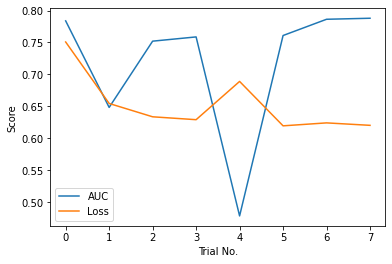

In [13]:
dfs = result.fetch_trial_dataframes()

aucs = []
losses = []
for d in dfs.values():
  aucs.append(d.auc)
  losses.append(d.loss)

plt.plot(range(0, 8), aucs, label="AUC")
plt.plot(range(0, 8), losses, label="Loss")
plt.legend()
plt.xlabel("Trial No.")
plt.ylabel("Score")


best candidates appear to come from trials 2,3,  & 5.

*   List item
*   List item


let's evaluate both

In [13]:
from functools import partial

def model_init():
   return BertForSequenceClassification.from_pretrained('bert-large-uncased',
                                                        num_labels=2,
                                                        output_attentions=False,
                                                        output_hidden_states=False)   

   
config = {
    "lr": tune.choice([5e-5,3e-5,2e-5]),
    "eps": tune.choice([1e-6]),
    "weight_decay": tune.choice([0]),
    "batch_size": tune.choice([16, 32]),
    "epochs": tune.choice([2,3, 4])
}

scheduler = ASHAScheduler(
    metric="auc",
    mode="max",
    max_t=10,
    grace_period=1,
    reduction_factor=2
)

reporter = CLIReporter(metric_columns=["loss", "auc", "training_iteration"])
hyperopt_search = HyperOptSearch(metric="auc", mode="max")

result = tune.run(
    partial(train_and_hyperparam_search, model_init=model_init, data=dataset_clf, cv=3),
    resources_per_trial={"cpu": 2, "gpu": 1},
    config=config,
    num_samples=8,
    scheduler=scheduler,
    search_alg=hyperopt_search,
    progress_reporter=reporter
)

2020-12-08 04:32:31,912	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265
2020-12-08 04:32:35,131	WARNING experiment.py:274 -- No name detected on trainable. Using DEFAULT.
2020-12-08 04:32:35,132	INFO registry.py:65 -- Detected unknown callable for trainable. Converting to class.
2020-12-08 04:32:35,136	WARNING function_runner.py:540 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


== Status ==
Memory usage on this node: 1.4/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.52 GiB heap, 0.0/2.59 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2020-12-08_04-32-35
Number of trials: 1/8 (1 RUNNING)
+------------------+----------+-------+--------------+----------+-------+-------+----------------+
| Trial name       | status   | loc   |   batch_size |   epochs |   eps |    lr |   weight_decay |
|------------------+----------+-------+--------------+----------+-------+-------+----------------|
| DEFAULT_64ff12fa | RUNNING  |       |           32 |        3 | 1e-06 | 3e-05 |              0 |
+------------------+----------+-------+--------------+----------+-------+-------+----------------+




(pid=3342) 2020-12-08 04:32:36.615637: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=3342) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3342) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3342) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (

(pid=3342) Device: cuda
(pid=3342) Training loss for epoch 1: 0.6692748904228211
(pid=3342) Training loss for epoch 2: 0.5258093875646591
(pid=3342) Training loss for epoch 3: 0.3100306811928749


(pid=3342) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3342) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3342) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3342) Some weights of BertForSequenceClassification were

(pid=3342) Device: cuda
(pid=3342) Training loss for epoch 1: 0.6889145720005035
(pid=3342) Training loss for epoch 2: 0.6129453384876251
(pid=3342) Training loss for epoch 3: 0.47560290664434435


(pid=3342) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3342) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3342) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3342) Some weights of BertForSequenceClassification were

(pid=3342) Device: cuda
(pid=3342) Training loss for epoch 1: 0.7335677325725556
(pid=3342) Training loss for epoch 2: 0.7150760757923126
(pid=3342) Training loss for epoch 3: 0.7105982983112336
Result for DEFAULT_64ff12fa:
  auc: 0.6914513803998568
  date: 2020-12-08_04-45-28
  done: false
  experiment_id: ce5d5985ad6f4482a57ce5939cd7170c
  experiment_tag: 1_batch_size=32,epochs=3,eps=1e-06,lr=3e-05,weight_decay=0
  hostname: 3dbdeaba70c6
  iterations_since_restore: 1
  loss: 0.6423841114176645
  node_ip: 172.28.0.2
  pid: 3342
  time_since_restore: 770.2191460132599
  time_this_iter_s: 770.2191460132599
  time_total_s: 770.2191460132599
  timestamp: 1607402728
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 64ff12fa
  
== Status ==
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: 0.6914513803998568
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.52 GiB heap, 0.0/2.

(pid=3341) 2020-12-08 04:45:29.881480: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=3341) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3341) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3341) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (

(pid=3341) Device: cuda
(pid=3341) Training loss for epoch 1: 0.6736257445812225
(pid=3341) Training loss for epoch 2: 0.5824425190687179


(pid=3341) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3341) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3341) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3341) Some weights of BertForSequenceClassification were

(pid=3341) Device: cuda
(pid=3341) Training loss for epoch 1: 0.6819853901863098
(pid=3341) Training loss for epoch 2: 0.5430249333381653


(pid=3341) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3341) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3341) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3341) Some weights of BertForSequenceClassification were

(pid=3341) Device: cuda
(pid=3341) Training loss for epoch 1: 0.6975177121162415
(pid=3341) Training loss for epoch 2: 0.5991556799411774
Result for DEFAULT_650f99f4:
  auc: 0.745186523790104
  date: 2020-12-08_04-54-26
  done: false
  experiment_id: bde182d3436b495a92ec08a5c440f64b
  experiment_tag: 2_batch_size=32,epochs=2,eps=1e-06,lr=3e-05,weight_decay=0
  hostname: 3dbdeaba70c6
  iterations_since_restore: 1
  loss: 0.6089461175600688
  node_ip: 172.28.0.2
  pid: 3341
  time_since_restore: 535.3832182884216
  time_this_iter_s: 535.3832182884216
  time_total_s: 535.3832182884216
  timestamp: 1607403266
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 650f99f4
  
== Status ==
Memory usage on this node: 4.2/12.7 GiB
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: 0.7183189520949804
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.52 GiB heap, 0.0/2.59 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: 

(pid=3512) 2020-12-08 04:54:28.611629: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=3512) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3512) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3512) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (

(pid=3512) Device: cuda
(pid=3512) Training loss for epoch 1: 0.7092341762600523
(pid=3512) Training loss for epoch 2: 0.7095960390688193
(pid=3512) Training loss for epoch 3: 0.7089660209838791
(pid=3512) Training loss for epoch 4: 0.703097955145017


(pid=3512) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3512) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3512) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3512) Some weights of BertForSequenceClassification were

(pid=3512) Device: cuda
(pid=3512) Training loss for epoch 1: 0.7162659071912669
(pid=3512) Training loss for epoch 2: 0.7080549079962452
(pid=3512) Training loss for epoch 3: 0.7140601391744132
(pid=3512) Training loss for epoch 4: 0.7065302916247436


(pid=3512) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3512) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3512) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3512) Some weights of BertForSequenceClassification were

(pid=3512) Device: cuda
(pid=3512) Training loss for epoch 1: 0.6745883674934657
(pid=3512) Training loss for epoch 2: 0.6986678215590391
(pid=3512) Training loss for epoch 3: 0.7148925264676412
(pid=3512) Training loss for epoch 4: 0.7131923413035846
Result for DEFAULT_31e0cd12:
  auc: 0.5576848396582704
  date: 2020-12-08_05-13-29
  done: true
  experiment_id: 63e6eb09aea34726b9e672af0191d997
  experiment_tag: 3_batch_size=16,epochs=4,eps=1e-06,lr=5e-05,weight_decay=0
  hostname: 3dbdeaba70c6
  iterations_since_restore: 1
  loss: 0.6916508907576402
  node_ip: 172.28.0.2
  pid: 3512
  time_since_restore: 1139.295240163803
  time_this_iter_s: 1139.295240163803
  time_total_s: 1139.295240163803
  timestamp: 1607404409
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 31e0cd12
  
== Status ==
Memory usage on this node: 5.1/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: 0.6914513803998568
Resources 

(pid=3591) 2020-12-08 05:13:33.034826: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=3591) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3591) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3591) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (

(pid=3591) Device: cuda
(pid=3591) Training loss for epoch 1: 0.6610894754077449
(pid=3591) Training loss for epoch 2: 0.6587907957910287


(pid=3591) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3591) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3591) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3591) Some weights of BertForSequenceClassification were

(pid=3591) Device: cuda
(pid=3591) Training loss for epoch 1: 0.6819026942807015
(pid=3591) Training loss for epoch 2: 0.5923224070457497


(pid=3591) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3591) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3591) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3591) Some weights of BertForSequenceClassification were

(pid=3591) Device: cuda
(pid=3591) Training loss for epoch 1: 0.6566136205437207
(pid=3591) Training loss for epoch 2: 0.5925287939984389
Result for DEFAULT_72cad1fa:
  auc: 0.7125887256787613
  date: 2020-12-08_05-23-27
  done: false
  experiment_id: 15a03866ed0146b5b16ea5c03186b8c8
  experiment_tag: 4_batch_size=16,epochs=2,eps=1e-06,lr=2e-05,weight_decay=0
  hostname: 3dbdeaba70c6
  iterations_since_restore: 1
  loss: 0.6228359876573085
  node_ip: 172.28.0.2
  pid: 3591
  time_since_restore: 593.2399001121521
  time_this_iter_s: 593.2399001121521
  time_total_s: 593.2399001121521
  timestamp: 1607405007
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 72cad1fa
  
== Status ==
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: 0.702020053039309
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.52 GiB heap, 0.0/2.59 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: 

(pid=3639) 2020-12-08 05:23:29.862768: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=3639) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3639) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3639) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (

(pid=3639) Device: cuda
(pid=3639) Training loss for epoch 1: 0.6837799835205078
(pid=3639) Training loss for epoch 2: 0.5796168011426925
(pid=3639) Training loss for epoch 3: 0.5312744915485382
(pid=3639) Training loss for epoch 4: 0.4144663369655609


(pid=3639) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3639) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3639) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3639) Some weights of BertForSequenceClassification were

(pid=3639) Device: cuda
(pid=3639) Training loss for epoch 1: 0.6468720155954361
(pid=3639) Training loss for epoch 2: 0.4968733757734299
(pid=3639) Training loss for epoch 3: 0.3787252396345139
(pid=3639) Training loss for epoch 4: 0.2542352817207575


(pid=3639) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3639) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3639) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3639) Some weights of BertForSequenceClassification were

(pid=3639) Device: cuda
(pid=3639) Training loss for epoch 1: 0.67778469145298
(pid=3639) Training loss for epoch 2: 0.5940318322181701
(pid=3639) Training loss for epoch 3: 0.46662801295518874
(pid=3639) Training loss for epoch 4: 0.3353445766866207
Result for DEFAULT_1be00826:
  auc: 0.7435307191979917
  date: 2020-12-08_05-40-34
  done: false
  experiment_id: 51f775c8e9bc4b5199d79d508b6d4528
  experiment_tag: 5_batch_size=32,epochs=4,eps=1e-06,lr=5e-05,weight_decay=0
  hostname: 3dbdeaba70c6
  iterations_since_restore: 1
  loss: 0.7091321375469367
  node_ip: 172.28.0.2
  pid: 3639
  time_since_restore: 1023.2764966487885
  time_this_iter_s: 1023.2764966487885
  time_total_s: 1023.2764966487885
  timestamp: 1607406034
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 1be00826
  
== Status ==
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: 0.7125887256787613
Resourc

(pid=3701) 2020-12-08 05:40:36.413203: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=3701) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3701) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3701) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (

(pid=3701) Device: cuda
(pid=3701) Training loss for epoch 1: 0.6658939862251282
(pid=3701) Training loss for epoch 2: 0.5459538286924362
(pid=3701) Training loss for epoch 3: 0.3568506127595901
(pid=3701) Training loss for epoch 4: 0.20102380990982055


(pid=3701) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3701) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3701) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3701) Some weights of BertForSequenceClassification were

(pid=3701) Device: cuda
(pid=3701) Training loss for epoch 1: 0.6823783743381501
(pid=3701) Training loss for epoch 2: 0.5849812769889832
(pid=3701) Training loss for epoch 3: 0.4335847669839859
(pid=3701) Training loss for epoch 4: 0.29735022097826


(pid=3701) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3701) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3701) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3701) Some weights of BertForSequenceClassification were

(pid=3701) Device: cuda
(pid=3701) Training loss for epoch 1: 0.673695695400238
(pid=3701) Training loss for epoch 2: 0.5993942850828171
(pid=3701) Training loss for epoch 3: 0.4504946792125702
(pid=3701) Training loss for epoch 4: 0.3381682547926903
Result for DEFAULT_80868858:
  auc: 0.7679395579767133
  date: 2020-12-08_05-57-27
  done: false
  experiment_id: 15f83b1ca08d4597803d4a3cf5a138be
  experiment_tag: 6_batch_size=32,epochs=4,eps=1e-06,lr=2e-05,weight_decay=0
  hostname: 3dbdeaba70c6
  iterations_since_restore: 1
  loss: 0.6279510885973772
  node_ip: 172.28.0.2
  pid: 3701
  time_since_restore: 1009.2359342575073
  time_this_iter_s: 1009.2359342575073
  time_total_s: 1009.2359342575073
  timestamp: 1607407047
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: '80868858'
  
== Status ==
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: 0.7280597224383765
Resou

(pid=3766) 2020-12-08 05:57:28.955212: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=3766) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3766) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3766) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (

(pid=3766) Device: cuda
(pid=3766) Training loss for epoch 1: 0.7143387031555176
(pid=3766) Training loss for epoch 2: 0.6874774992465973


(pid=3766) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3766) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3766) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3766) Some weights of BertForSequenceClassification were

(pid=3766) Device: cuda
(pid=3766) Training loss for epoch 1: 0.7212314891815186
(pid=3766) Training loss for epoch 2: 0.628286537528038


(pid=3766) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3766) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3766) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3766) Some weights of BertForSequenceClassification were

(pid=3766) Device: cuda
(pid=3766) Training loss for epoch 1: 0.68878497838974
(pid=3766) Training loss for epoch 2: 0.6102926844358444
Result for DEFAULT_e48dfe1a:
  auc: 0.6701296879392956
  date: 2020-12-08_06-06-24
  done: true
  experiment_id: 5dad89444a1846c28231888ea3e5f837
  experiment_tag: 7_batch_size=32,epochs=2,eps=1e-06,lr=5e-05,weight_decay=0
  hostname: 3dbdeaba70c6
  iterations_since_restore: 1
  loss: 0.6724028853575388
  node_ip: 172.28.0.2
  pid: 3766
  time_since_restore: 533.6372172832489
  time_this_iter_s: 533.6372172832489
  time_total_s: 533.6372172832489
  timestamp: 1607407584
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e48dfe1a
  
== Status ==
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: 0.7125887256787613
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.52 GiB heap, 0.0/2.59 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /r

(pid=3811) 2020-12-08 06:06:26.174096: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
(pid=3811) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3811) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3811) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (

(pid=3811) Device: cuda
(pid=3811) Training loss for epoch 1: 0.6891255950927735
(pid=3811) Training loss for epoch 2: 0.6047997176647186
(pid=3811) Training loss for epoch 3: 0.43482783138751985


(pid=3811) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3811) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3811) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3811) Some weights of BertForSequenceClassification were

(pid=3811) Device: cuda
(pid=3811) Training loss for epoch 1: 0.6903380227088928
(pid=3811) Training loss for epoch 2: 0.5779154294729233
(pid=3811) Training loss for epoch 3: 0.37280466586351396


(pid=3811) Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
(pid=3811) - This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(pid=3811) - This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(pid=3811) Some weights of BertForSequenceClassification were

(pid=3811) Device: cuda
(pid=3811) Training loss for epoch 1: 0.6528354704380035
(pid=3811) Training loss for epoch 2: 0.4810764163732529
(pid=3811) Training loss for epoch 3: 0.3093424171209335


2020-12-08 06:19:22,633	INFO tune.py:439 -- Total run time: 6411.52 seconds (6407.45 seconds for the tuning loop).


Result for DEFAULT_400dd862:
  auc: 0.7802492532386718
  date: 2020-12-08_06-19-22
  done: false
  experiment_id: a0a46426c59043b7a2bbe428f1fa8767
  experiment_tag: 8_batch_size=32,epochs=3,eps=1e-06,lr=5e-05,weight_decay=0
  hostname: 3dbdeaba70c6
  iterations_since_restore: 1
  loss: 0.6392128335767322
  node_ip: 172.28.0.2
  pid: 3811
  time_since_restore: 774.9643497467041
  time_this_iter_s: 774.9643497467041
  time_total_s: 774.9643497467041
  timestamp: 1607408362
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 400dd862
  
== Status ==
Memory usage on this node: 4.3/12.7 GiB
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: 0.7280597224383765
Resources requested: 2/2 CPUs, 1/1 GPUs, 0.0/7.52 GiB heap, 0.0/2.59 GiB objects (0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/DEFAULT_2020-12-08_04-32-35
Number of trials: 8/8 (1 RUNNING, 7 TERMINATED)
+------------------+------------+----------

In [14]:
def train(model, epochs, train_dataloader, test_dataloader, optimizer, scheduler):
  for epoch in tqdm(range(1, epochs+1)): # use tqdm for a progress bar
    model.train() # enter training mode
    loss_train_total = 0

    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch}', leave=False, disable=False)
    for batch in progress_bar:
        model.zero_grad()
        
        # get CUDA data
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids':      batch[0],
            'attention_mask': batch[1],
            'labels':         batch[2],
        }

        outputs = model(**inputs) # evaluate
        
        # for reference, we are using cross-entropy loss here,
        # as implemented in https://huggingface.co/transformers/_modules/transformers/modeling_bert.html
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward() # do backprop

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
          
        
    torch.save(model.state_dict(), f'/content/drive/MyDrive/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_dataloader)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(model, test_dataloader, device)
    auc = auc_score(predictions, true_vals)
    tqdm.write(f'Testing loss: {val_loss}')
    tqdm.write(f'AUC: {auc}')

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(dataset_clf.index.values, 
                                                  dataset_clf.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=dataset_clf.label.values)

dataset_clf['data_type'] = ['not_set']*dataset_final.shape[0]

dataset_clf.loc[X_train, 'data_type'] = 'train'
dataset_clf.loc[X_val, 'data_type'] = 'test'

dataset_train = dataset_clf.loc[dataset_clf.data_type == 'train']
dataset_test = dataset_clf.loc[dataset_clf.data_type == 'test']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [ ]:
# model 1
# |  batch_size |   epochs |         eps |          lr |   weight_decay |
# |           16 |        2 | 4.94087e-09 | 1.19201e-05|    5.42786e-09 |

encoded_data_train = tokenizer.batch_encode_plus(
    dataset_clf[dataset_clf.data_type=='train'].clean_text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    max_length=64, 
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    dataset_clf[dataset_clf.data_type=='test'].clean_text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    max_length=64, 
    return_tensors='pt'
)


# destructure out the input_ids, attention masks, and labels from tokenizer & encoder output
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset_clf[dataset_clf.data_type=='train'].label.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(dataset_clf[dataset_clf.data_type=='test'].label.values)

train_data = TensorDataset(input_ids_train, attention_masks_train, labels_train)
test_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)

train_dataloader = DataLoader(train_data, 
                              sampler=RandomSampler(train_data), 
                              batch_size=16)

test_dataloader = DataLoader(test_data,
                            sampler=SequentialSampler(test_data),
                            batch_size=16)
